In [19]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [20]:
#Memuat dataset
df = pd.read_csv('../Dataset/secondhanddataset.csv')
print(df.head())

   v.id  on road old  on road now  years      km  rating  condition  economy  \
0     1       535651       798186      3   78945       1          2       14   
1     2       591911       861056      6  117220       5          9        9   
2     3       686990       770762      2  132538       2          8       15   
3     4       573999       722381      4  101065       4          3       11   
4     5       691388       811335      6   61559       3          9       12   

   top speed  hp  torque  current price  
0        177  73     123       351318.0  
1        148  74      95       285001.5  
2        181  53      97       215386.0  
3        197  54     116       244295.5  
4        160  53     105       531114.5  


In [21]:
#Pisahkan kolom v.id
X = df.drop(columns=['v.id'])
y = df['current price'].values.reshape(-1, 1)

In [22]:
#Pilih kolom dengan tipe data numerik dan kategorikal
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(columns=['current price'], errors='ignore').columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [23]:
#Mengisi data yang hilang dan melakukan scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [24]:
#Mengisi data yang hilang dan melakukan encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [25]:
#Menggabungkan kedua transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [26]:
X = preprocessor.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

In [27]:
#Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [28]:
#Konversi data menjadi tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [29]:
#Definisikan model pytorch
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=1024):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.out = nn.Linear(hidden_size // 4, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.out(x)

In [30]:
input_size = X_train.shape[1]
model_pt = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

In [31]:
#Latih model
for epoch in range(100):
    model_pt.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_pt(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{100}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/100, Loss: 0.0946
Epoch 2/100, Loss: 0.0147
Epoch 3/100, Loss: 0.0093
Epoch 4/100, Loss: 0.0086
Epoch 5/100, Loss: 0.0085
Epoch 6/100, Loss: 0.0111
Epoch 7/100, Loss: 0.0074
Epoch 8/100, Loss: 0.0063
Epoch 9/100, Loss: 0.0071
Epoch 10/100, Loss: 0.0055
Epoch 11/100, Loss: 0.0067
Epoch 12/100, Loss: 0.0063
Epoch 13/100, Loss: 0.0060
Epoch 14/100, Loss: 0.0053
Epoch 15/100, Loss: 0.0052
Epoch 16/100, Loss: 0.0054
Epoch 17/100, Loss: 0.0046
Epoch 18/100, Loss: 0.0036
Epoch 19/100, Loss: 0.0048
Epoch 20/100, Loss: 0.0044
Epoch 21/100, Loss: 0.0028
Epoch 22/100, Loss: 0.0033
Epoch 23/100, Loss: 0.0037
Epoch 24/100, Loss: 0.0056
Epoch 25/100, Loss: 0.0039
Epoch 26/100, Loss: 0.0038
Epoch 27/100, Loss: 0.0037
Epoch 28/100, Loss: 0.0060
Epoch 29/100, Loss: 0.0035
Epoch 30/100, Loss: 0.0035
Epoch 31/100, Loss: 0.0038
Epoch 32/100, Loss: 0.0026
Epoch 33/100, Loss: 0.0030
Epoch 34/100, Loss: 0.0029
Epoch 35/100, Loss: 0.0029
Epoch 36/100, Loss: 0.0062
Epoch 37/100, Loss: 0.0052
Epoch 38/1

In [32]:
#Definisikan model tensorflow
class MLP_TF(tf.keras.Model):
    def __init__(self, input_size, hidden_size=1024):
        super(MLP_TF, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.fc2 = tf.keras.layers.Dense(hidden_size // 2, activation='relu')
        self.fc3 = tf.keras.layers.Dense(hidden_size // 4, activation='relu')
        self.fc4 = tf.keras.layers.Dense(1)

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.dropout1(x, training=training)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.fc4(x)

In [33]:
model_tf = MLP_TF(input_size)
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model_tf.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2327
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoc

In [34]:
#Evaluasi model
model_pt.eval()
with torch.no_grad():
    y_pred_pt = model_pt(X_test_tensor).numpy()
y_pred_tf = model_tf.predict(X_test)

y_pred_pt = scaler_y.inverse_transform(y_pred_pt)
y_pred_tf = scaler_y.inverse_transform(y_pred_tf)
y_test_orig = scaler_y.inverse_transform(y_test)

mse_pt = mean_squared_error(y_test_orig, y_pred_pt)
mse_tf = mean_squared_error(y_test_orig, y_pred_tf)
print(f'PyTorch MSE: {mse_pt:.4f}, TensorFlow MSE: {mse_tf:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
PyTorch MSE: 52796343.1150, TensorFlow MSE: 16690992.4614


In [35]:
#Contoh prediksi
random_idx = random.randint(0, X_test.shape[0] - 1)
sample_input = X_test[random_idx].reshape(1, -1)
true_price = scaler_y.inverse_transform(y_test[random_idx].reshape(1, -1))[0][0]

sample_tf_pred = scaler_y.inverse_transform(model_tf.predict(sample_input))[0][0]

sample_tensor = torch.tensor(sample_input, dtype=torch.float32)
with torch.no_grad():
    sample_pt_pred = scaler_y.inverse_transform(model_pt(sample_tensor).numpy())[0][0]

print("=== Sample Prediction Comparison ===")
print(f"True Price           : {true_price:.2f}")
print(f"PyTorch Prediction   : {sample_pt_pred:.2f}")
print(f"TensorFlow Prediction: {sample_tf_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
=== Sample Prediction Comparison ===
True Price           : 383570.50
PyTorch Prediction   : 384586.88
TensorFlow Prediction: 385971.22


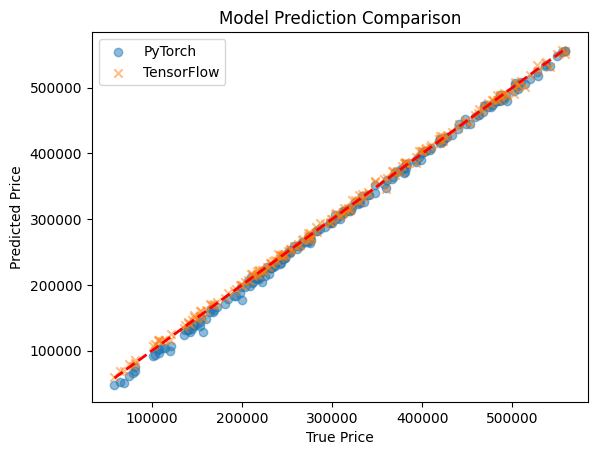

In [36]:
#Visualisasi hasil prediksi
plt.scatter(y_test_orig, y_pred_pt, alpha=0.5, label='PyTorch')
plt.scatter(y_test_orig, y_pred_tf, alpha=0.5, label='TensorFlow', marker='x')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', linewidth=2)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Model Prediction Comparison")
plt.legend()
plt.show()

# **Penjelasan Persamaan Matematika dalam Kode**

## **1. Normalisasi Data dengan StandardScaler**
Pada preprocessing, kita melakukan **standardisasi** terhadap fitur numerik dan target menggunakan StandardScaler:

**Rumus:**
```
X' = (X - μ) / σ
```

**Keterangan:**
- `X` adalah nilai asli fitur atau target  
- `μ` adalah rata-rata dari fitur tersebut  
- `σ` adalah standar deviasi dari fitur tersebut  

Standardisasi ini dilakukan agar semua fitur memiliki skala yang seragam sehingga model lebih stabil saat pelatihan.

---

## **2. Forward Propagation dalam MLP**
Model yang digunakan adalah **Multi-Layer Perceptron (MLP)** yang terdiri dari beberapa lapisan.  

**Proses perhitungan dalam model:**
```
h1 = ReLU(W1 * X + b1)
h2 = ReLU(W2 * h1 + b2)
h3 = ReLU(W3 * h2 + b3)
ŷ = W4 * h3 + b4
```

**Keterangan:**
- `X` adalah input  
- `Wi` adalah bobot pada lapisan `i`  
- `bi` adalah bias pada lapisan `i`  
- `hi` adalah output dari lapisan tersembunyi ke-`i`  
- `ReLU(x)` adalah fungsi aktivasi **ReLU** dengan rumus:  
  ```
  ReLU(x) = max(0, x)
  ```
- `ŷ` adalah output prediksi dari model  

Fungsi aktivasi ReLU digunakan untuk menangani non-linearitas dalam data.

---

## **3. Fungsi Loss: Mean Squared Error (MSE)**
Model menggunakan **Mean Squared Error (MSE)** sebagai fungsi loss:

**Rumus:**
```
MSE = (1/n) * Σ (yi - ŷi)²
```

**Keterangan:**
- `yi` adalah nilai aktual (ground truth)  
- `ŷi` adalah nilai prediksi  
- `n` adalah jumlah sampel  

MSE memberikan penalti lebih besar pada kesalahan besar sehingga model lebih sensitif terhadap outlier.

---

## **4. Optimasi dengan Adam Optimizer**
Adam Optimizer digunakan untuk mempercepat konvergensi dan meningkatkan stabilitas pembelajaran.

**Rumus perhitungan Adam Optimizer:**
```
mt = β1 * mt-1 + (1 - β1) * gt
vt = β2 * vt-1 + (1 - β2) * gt²
m̂t = mt / (1 - β1^t)
v̂t = vt / (1 - β2^t)
θt = θt-1 - (α * m̂t) / (√(v̂t) + ε)
```

**Keterangan:**
- `gt` adalah gradien dari loss  
- `mt` adalah momentum gradien  
- `vt` adalah akumulasi gradien kuadrat  
- `β1` dan `β2` adalah hyperparameter (biasanya 0.9 dan 0.999)  
- `α` adalah learning rate  
- `θ` adalah bobot model  

Adam Optimizer lebih adaptif dibandingkan **SGD (Stochastic Gradient Descent)** karena menyesuaikan learning rate berdasarkan gradien sebelumnya.

---

## **5. Evaluasi Model**
Setelah model dilatih, dilakukan evaluasi menggunakan **RMSE** dan **R² Score**.

### **a) Root Mean Squared Error (RMSE)**
**Rumus:**
```
RMSE = √MSE = √((1/n) * Σ (yi - ŷi)²)
```
RMSE memberikan nilai error dalam satuan yang sama dengan target.

### **b) R² Score (Koefisien Determinasi)**
**Rumus:**
```
R² = 1 - (Σ (yi - ŷi)² / Σ (yi - ȳ)²)
```

**Keterangan:**
- `ȳ` adalah rata-rata dari nilai aktual  
- Nilai `R²` berkisar antara `0 hingga 1`, semakin mendekati `1`, semakin baik prediksi model  

---

## **6. Denormalisasi Output Model**
Setelah model memprediksi nilai harga, hasilnya dikembalikan ke skala asli dengan **inverse transform** dari StandardScaler:

**Rumus:**
```
y_real = ŷ * σy + μy
```

**Keterangan:**
- `ŷ` adalah output prediksi yang masih dalam skala standar  
- `σy` adalah standar deviasi dari target  
- `μy` adalah rata-rata target  

Ini dilakukan agar hasil prediksi bisa dibandingkan dengan data asli dalam satuan harga.